In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn
import bindingdata
import logomaker
from importlib import reload
import motifscanner

#IP_peak_file = "/gpfs/commons/home/daknowles/RIPnet/all_hnrnpk_rep1_stranded.narrowPeak.gz"
IP_peak_file = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/alignments/macs/all_hnrnpa1_rep1_stranded_noigg.narrowPeak"
unbound_bed_file = "unbound_regions/HNRNPK_unbound.bed.gz"
RBP = "HNRNPK"
pwm_source = "K562" # "oRNAment" # HepG2, K562 both imply mCross

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [3]:
binding_data = pd.read_csv(IP_peak_file, sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data

,chrom,start,end,name,score,strand
0,chr1,127536,127943,all_hnrnpa1_rep1_neg_peak_12,41,-
1,chr1,191637,191988,all_hnrnpa1_rep1_neg_peak_13,36,-
2,chr1,629319,630038,all_hnrnpa1_rep1_neg_peak_14,110,-
3,chr1,631825,632208,all_hnrnpa1_rep1_neg_peak_15,98,-
31363,chr1,784227,784579,all_hnrnpa1_rep1_pos_peak_6,43,+
...,...,...,...,...,...,...
63198,chr9,138045301,138045718,all_hnrnpa1_rep1_pos_peak_33782,41,+
63199,chr9,138048184,138048529,all_hnrnpa1_rep1_pos_peak_33783,70,+
63200,chr9,138066617,138067377,all_hnrnpa1_rep1_pos_peak_33784,60,+
63201,chr9,138080351,138081203,all_hnrnpa1_rep1_pos_peak_33785,76,+


In [4]:
unbound = pd.read_csv(unbound_bed_file, 
                      sep = "\t", 
                      names = ["chrom", "start", "end", "name", "strand", "counts", "length"],
                      index_col = False)
unbound

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,chrom,start,end,name,strand,counts,length
0,chr1,17369,17436,ENSG00000278267.1,-,53,68
1,chr1,135141,135895,ENSG00000268903.1,-,903,755
2,chr1,137682,137965,ENSG00000269981.1,-,1206,284
3,chr1,185217,186383,ENSG00000279457.4,-,295,1397
4,chr1,187169,190825,ENSG00000279457.4,-,295,1397
...,...,...,...,...,...,...,...
101498,chrM,14149,14673,ENSG00000198695.2,-,59390,525
101499,chrM,14674,14742,ENSG00000210194.1,-,598,69
101500,chrM,14747,15887,ENSG00000198727.2,+,247327,1141
101501,chrM,15888,15953,ENSG00000210195.2,+,663,66


In [5]:
unbound["score"] = 0
bind_all = pd.concat([binding_data,
           unbound.loc[:, ~unbound.columns.isin(['counts', 'length'])]], 
          axis=0)
bind_all.iloc[10]

chrom                             chr1
start                           957695
end                             958000
name      all_hnrnpa1_rep1_neg_peak_21
score                               81
strand                               -
Name: 8, dtype: object

In [6]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.09645310958156868, 0.1482314580434796)

We'll also need the human genome, which we provide here as a pickle since it's faster to load compared to reading in a text file. 

It's worth knowing that the human genome has different *versions* that are released as more missing parts are resolved by continued sequencing and assembly efforts. Version `GRCh37` (also called `hg19`) was released in 2009, and `GRCh38` (`hg38`) was released in 2013. We'll be using `hg19` here but `GRCh38` is finally becoming more standard so always check your data is what you think it is. 

This will take a minute or two. 

In [7]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

`genome` is just a dictionary where the keys are the chromosome names and the values are strings representing the actual DNA. Ns represents "missing" regions, typically because the region has too many repetitive sequences making mapping impossible, which is especially the case in [centrosomes](https://en.wikipedia.org/wiki/Centrosome) and [telomeres](https://en.wikipedia.org/wiki/Telomere). Resolving these difficult to map regions is an ongoing effort. 

## Load known PWMs

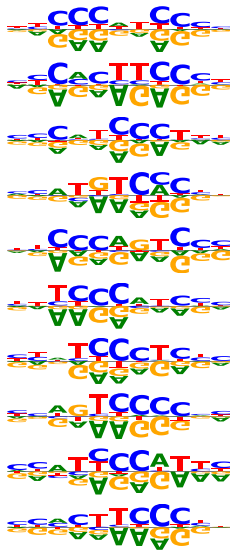

In [8]:
if pwm_source == "oRNAment":
    pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
    pwm_names = pwm_dat['names']
    pwms = pwm_dat['pwms']

    pwms[pwms > 0].min()
    log_pwms = np.log(pwms + 1e-4)

    # Convert to actual PWM
    w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
    w_norm = w - w.mean(1,keepdims=True)

    specific_pwms = w_norm[ np.array([ RBP in g for g in pwm_names ]) ]
    specific_pwms.shape
else: 
    base_dir = "/gpfs/commons/groups/knowles_lab/data/oRNAment/mCross/"
    pwm = np.load(base_dir + "mCross_pwm.npy")
    meta = pd.read_csv(base_dir + "pwm_meta.tsv", sep = "\t")
    #specific_motifs = (meta.RBP == RBP) & (meta.Celltype == "HepG2").to_numpy()
    
    specific_motifs = (meta.RBP == RBP) & (meta.Celltype == pwm_source).to_numpy()
    specific_pwms = torch.tensor(pwm[specific_motifs,:,:], dtype = torch.float)
    specific_pwms -= specific_pwms.mean(1, keepdims=True)

biophysnn.plot_motifs(specific_pwms)

In [9]:
validation_data

,chrom,start,end,name,score,strand
13560,chr2,151490,152038,all_hnrnpa1_rep1_neg_peak_14501,89,-
13561,chr2,231153,231367,all_hnrnpa1_rep1_neg_peak_14502,56,-
13562,chr2,243669,244080,all_hnrnpa1_rep1_neg_peak_14503,48,-
13563,chr2,674771,675187,all_hnrnpa1_rep1_neg_peak_14505,44,-
45962,chr2,957107,958252,all_hnrnpa1_rep1_pos_peak_15679,76,+
...,...,...,...,...,...,...
23113,chr3,197962109,198012351,ENSG00000185621.11,0,+
23114,chr3,198014275,198014631,ENSG00000185621.11,0,+
23115,chr3,198015944,198043720,ENSG00000185621.11,0,+
23116,chr3,198153287,198182452,ENSG00000236438.7,0,+


## Test phys net

In [10]:
base_checkpoint_dir =  "checkpoints/%s_%s/" % (RBP, pwm_source)
res_file  = "biophys_results/test_settings_%s_%s.tsv" % (RBP, pwm_source)

if os.path.isfile(res_file): 
    res_df = pd.read_csv(res_file, sep="\t", index_col = False)
else: 
    res_df = motifscanner.test_settings(
        specific_pwms, 
        train_data, 
        validation_data,
        genome, 
        base_checkpoint_dir = base_checkpoint_dir)
    res_df.to_csv(res_file, sep = "\t", index = False)

### Analyze results

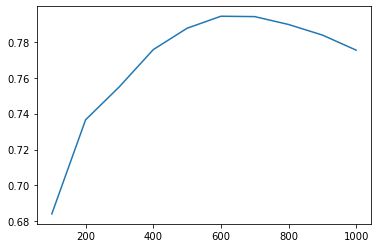

In [11]:
lse_only = res_df[~res_df.posmax & ~res_df.motifmax]
plt.plot(lse_only.seqlen, lse_only.val_auc)

In [12]:
sixh_only = res_df.groupby(["motifmax","posmax","motif_then_pos"]).agg({"val_auc" : "max"})
sixh_only

val_auc
motifmax posmax motif_then_pos          
False    False  True            0.794267
         True   False           0.760769
                True            0.712797
True     False  False           0.777346
                True            0.797447
         True   True            0.698540

The best performance is obtained by using logSumExp across both motifs and positions, which is symmetric in the order of summarization. Taking the max over positions always performs very poorly, suggesting that accounting for multiple binding sites in the region is beneficial, at least for HNRNPK. 

Taking the max over motifs but logSumExp over positions gives intermediate performance. Interestingly, it is better to do the max over motifs first, then logSumExp over positions (rather than logSumExp over positions then max over motifs). This is intuitive. If there are two distinct binding sites in a region, there is no reason to think that the same motif need be used in both. Instead, the max determines how likely the RBP is to bind at any given position, and this is combined by the logSumExp. 

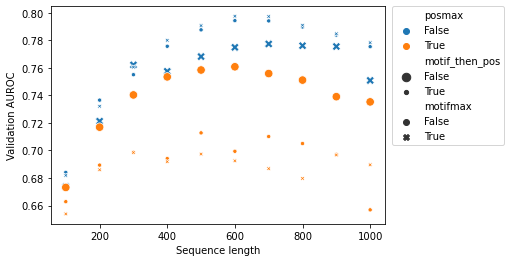

In [13]:
import seaborn as sns
#res_df = pd.read_csv("biophys_results/results.tsv", sep="\t", index_col = False)
sns.scatterplot("seqlen", "val_auc", hue = "posmax", style="motifmax", size="motif_then_pos", data = res_df)
plt.xlabel("Sequence length")
plt.ylabel("Validation AUROC")
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)

In [14]:
res_df

,posmax,motifmax,seqlen,file,motif_then_pos,val_auc,train_auc
0,False,False,100,checkpoints/HNRNPK_K562/posmax0_motifmax0_len1...,True,0.684111,0.680001
1,False,False,200,checkpoints/HNRNPK_K562/posmax0_motifmax0_len2...,True,0.736566,0.727331
2,False,False,300,checkpoints/HNRNPK_K562/posmax0_motifmax0_len3...,True,0.755009,0.748019
3,False,False,400,checkpoints/HNRNPK_K562/posmax0_motifmax0_len4...,True,0.775660,0.765940
4,False,False,500,checkpoints/HNRNPK_K562/posmax0_motifmax0_len5...,True,0.787576,0.775835
5,False,False,600,checkpoints/HNRNPK_K562/posmax0_motifmax0_len6...,True,0.794267,0.779166
6,False,False,700,checkpoints/HNRNPK_K562/posmax0_motifmax0_len7...,True,0.794066,0.779663
7,False,False,800,checkpoints/HNRNPK_K562/posmax0_motifmax0_len8...,True,0.789677,0.772853
8,False,False,900,checkpoints/HNRNPK_K562/posmax0_motifmax0_len9...,True,0.783791,0.768311
9,False,False,1000,checkpoints/HNRNPK_K562/posmax0_motifmax0_len1...,True,0.775373,0.759050


In [21]:
best_i = res_df.val_auc.argmax()
check_point_filename = res_df.file.iloc[best_i]
phys_net = motifscanner.PhysNet(
    specific_pwms, 
    max_over_positions = res_df.posmax.iloc[best_i], 
    max_over_motifs = res_df.motifmax.iloc[best_i], 
    seq_len = res_df.seqlen.iloc[best_i],
    motif_then_pos = res_df.motif_then_pos.iloc[best_i] )
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phys_net.load_state_dict(torch.load(check_point_filename))
for k,v in phys_net.named_parameters(): 
    print(k,v)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
phys_net.scale

In [ ]:
phys_net.motif_scale

### Plot examples

Only look at positive (bound) sequences. 

In [ ]:
val_dataset = bindingdata.FastBedPeaksDataset(validation_data, genome, phys_net.seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10000)
for x,y in validation_dataloader: 
    affin = phys_net(x)
    conv_lin = F.conv1d(x, phys_net.pwm, padding = "same") * phys_net.motif_scale[None,:,None] + phys_net.motif_offset[None,:,None]
    per_position = phys_net.scale * conv_lin.logsumexp(1) + phys_net.offset
    break

bound = y == 1.
idx = affin[bound].argmax().item() # find the bound peak with the highest predicted binding
plt.plot(per_position[bound][idx].detach().exp().numpy()) # plot per position binding affinity

argmax_pos = per_position[bound][idx].argmax().item() # find the most strongly bound position
argmax_motif = conv_lin[bound][idx,:,argmax_pos].argmax().item() # find the 
argmax_pos, argmax_motif

In [ ]:
one_motif = phys_net.scale * conv_lin[bound][idx,argmax_motif] + phys_net.offset
plt.plot(one_motif.detach().exp().numpy())

Clusters are cool.

In [ ]:
pwm_match = phys_net.pwm[argmax_motif,:,:]

pwm_df = pd.DataFrame(data = pwm_match.detach().t().numpy(), columns=("A","C","G","T"))
crp_logo = logomaker.Logo(pwm_df) 
plt.axis('off')

In [ ]:
one_motif.argmax().item()

In [ ]:
npos = 10
context = 7
top_pos = one_motif.argsort(descending=True)[:npos]
plt.figure(figsize=(4,npos))
xbound = F.pad(x[bound], (context,context))
for i,tp in enumerate(top_pos):
    ax = plt.subplot(npos,1,i+1)
    plt.axis('off')
    seq = xbound[idx,:,tp:tp+context*2]
    pwm_df = pd.DataFrame(data = seq.detach().t().numpy(), columns=("A","C","G","T"))
    crp_logo = logomaker.Logo(pwm_df, ax= ax) 

## Fine tune PWMs

In [ ]:
scaled_pwm = specific_pwms * phys_net.motif_scale[:,None,None]
fine_net = motifscanner.FinePhysNet(scaled_pwm, 
                                 motif_offset = phys_net.motif_offset.data,
                                 scale_unc = phys_net.scale_unc.data, 
                                 offset = phys_net.offset.data, 
                                 seq_len = phys_net.seq_len)
val_metrics_list, train_metrics_list = biophysnn.train_model(fine_net, 
                                   train_data, 
                                   validation_data, 
                                   genome, 
                                   verbose = True, 
                                   check_point_filename = base_checkpoint_dir + "/fine_net.pt",
                                   lr = 0.1) # val auc 0.832



So fine-tuning moves AUROC from 0.81 to 0.86, and does significantly change the PWMs: 

In [ ]:
biophysnn.plot_motifs(specific_pwms)

In [ ]:
biophysnn.plot_motifs(fine_net.pwm.cpu())

In [ ]:
val_metrics = val_metrics_list[-1]
res_file  = "biophys_results/finetune_%s_%s.tsv" % (RBP, pwm_source)
pd.DataFrame(val_metrics._asdict(), index=[0]).to_csv(
    res_file, sep = "\t", index = False)
val_metrics